In [1]:
import cv2
from math import copysign, log10
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


ModuleNotFoundError: No module named 'pandas'

# Object description

We are going to use the Hu Moments to describe and group different objects in images. In the folder called _data_ you can find a simple image with different objects.

## Load and binarize the image

The first job is to load the image and binarize it. It is important to load the image using the `cv2.IMREAD_GRAYSCALE` parameter in order to obtain a 2D matrix. Show the binarized image in order to check this part of the process.

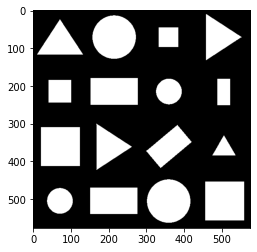

In [ ]:
filename = "../data/simple_shapes.png"
im = cv2.imread(filename, 0)
im_binary = np.ones_like(im)
im_binary[im>254] = 0
plt.imshow(im_binary, cmap = 'gray')

## Contour detection

As you did in the segmentation assignment of the Image Analysis subject, you have to use the `findContours` function to detect all the objects in the image. In order to check if you have performed a correct detection you have to draw the contours on the image and visualize them.

_Extra_: Given a contour, you can obtain its bounding box by using the `boundingRect` function.


In [ ]:
contours, _ = cv2.findContours(im_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
region_mask = np.zeros_like(im)
for contour in contours:
  # Drawing the contours for visualization
  region_mask = cv2.drawContours(region_mask, [contour], 0, 255, -1)

16


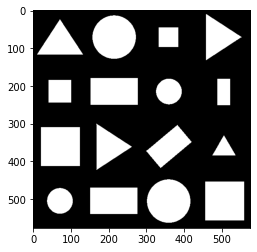

In [ ]:
plt.imshow(region_mask, 'gray')
plt.show()

## Descriptor

As we stated before, you are going to describe each object by means of the *moments*. _OpenCV_ has a built-in function for calculating Hu Moments. It is called `HuMoments` and it takes as input the central moments of the image which can be calculated using the function `moments`. The function `moments` can receive a binary image or a set of points describing a contour.

The Hu Moments obtained have a large range, so we can apply a log transform by using next code: `moment_i = -1* copysign(1.0, moment_i) * log10(abs(moment_i)))`. The `copysign` and `log10` functions are part of the _math_ library.


In [ ]:
rgn_mask_mmnts = region_mask.copy()
regional_huMoments = np.zeros((len(contours), 7))
for j, contour in enumerate(contours):
  M = cv2.moments(contour)
  try:
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
  except:
    continue
  huMoments = cv2.HuMoments(M)
  # huMoments = -1* np.copysign(1.0, huMoments) * np.log10(np.abs(huMoments), where = huMoments!=0))
  for i in range(0, 7):
    # Works more accurately without scaling
    # if huMoments[i] != 0:
    #   huMoments[i] = -1* copysign(1.0, huMoments[i]) * log10(abs(huMoments[i]))
    regional_huMoments[j, i] = huMoments[i]
  # Identifying which index represents which shape/contour
  cv2.circle(rgn_mask_mmnts, (cX, cY), 5, 0, -1)
  cv2.putText(rgn_mask_mmnts, str(j), (cX - 10, cY - 10),cv2.FONT_HERSHEY_SIMPLEX, .7, 0, 2)

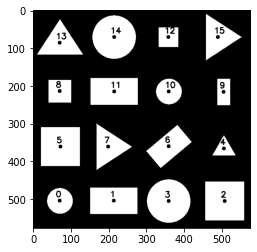

In [ ]:
plt.imshow(rgn_mask_mmnts, 'gray')

## Shape matching

Now you have a descriptor for each object. Next step is to calculate the euclidean distance between the shapes and try to obtain groups of similar objects.

**This is a challenging step!!**

In [ ]:
shape_group = {}
class_idx = 1
for i in range(len(contours)):
  dist = []
  for j in range(len(contours)):
    if i != j:
      dist.append(np.linalg.norm(regional_huMoments[i] - regional_huMoments[j]))
    else:
      dist.append(100000)

  # Considering least two distances, \
  # checks if etiher of them already belongs to a group and assigns the index accordingly\
  # else a new group index is used
  if i not in shape_group and np.argmin(dist) not in shape_group and np.argsort(dist)[1] not in shape_group:
    shape_group[i] = class_idx
    shape_group[np.argmin(dist)] = class_idx # closest shape
    shape_group[np.argsort(dist)[1]] = class_idx # second closest shape
    class_idx += 1 # Create new class index

  elif i in shape_group and np.argmin(dist) not in shape_group and np.argsort(dist)[1] not in shape_group:
    shape_group[np.argmin(dist)] = shape_group[i]
    shape_group[np.argsort(dist)[1]] = shape_group[i]

  elif i not in shape_group and np.argmin(dist) in shape_group and np.argsort(dist)[1] not in shape_group:
    shape_group[i] = shape_group[np.argmin(dist)]
    shape_group[np.argsort(dist)[1]] = shape_group[np.argmin(dist)]

  elif i not in shape_group and np.argmin(dist) not in shape_group and np.argsort(dist)[1] in shape_group:
    shape_group[i] = shape_group[np.argsort(dist)[1]]
    shape_group[np.argmin(dist)] = shape_group[np.argsort(dist)[1]]

  elif i not in shape_group:
    if shape_group[np.argmin(dist)] != shape_group[np.argsort(dist)[1]]:
      raise RuntimeError("CONFLICT", np.argmin(dist), np.argsort(dist)[1])
    shape_group[i] = shape_group[np.argmin(dist)]

In [ ]:
im_color = cv2.imread(filename)
colors = [(115, 120, 168), (246, 10, 231), (80, 231, 216),(253, 43, 188),(67, 64, 92),(239, 144, 217),(249, 58, 204),(227, 153, 141),(47, 217, 12),(191, 254, 204),(58, 85, 252),(229, 163, 167),(101, 104, 136),(68, 114, 196),(66, 172, 62)]
for i, contour in enumerate(contours):
  cv2.drawContours(im_color, [contour], 0, (0,0,0), 2)
  cv2.drawContours(im_color, [contour], 0, colors[shape_group[i]], -1)

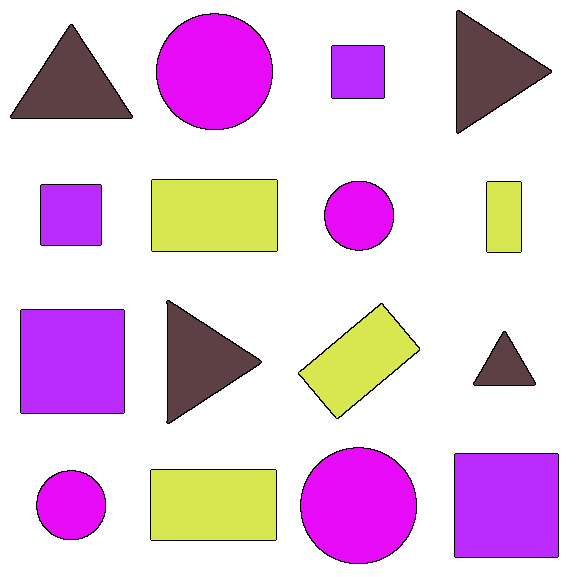

In [ ]:
cv2_imshow(im_color)

Other Attempts

In [ ]:
# cosine distance produces same results as euclidean distance
from scipy.spatial.distance import cosine
shape_group = []
for i in range(len(contours)):
  dist = []
  for j in range(len(contours)):
    if i != j:
      dist.append(cosine(regional_huMoments[i], regional_huMoments[j]))
    else:
      dist.append(100000)
  print(f"{i}th contour has the same shape as {np.argmin(dist)}")

0th contour has the same shape as 10
1th contour has the same shape as 11
2th contour has the same shape as 5
3th contour has the same shape as 14
4th contour has the same shape as 15
5th contour has the same shape as 2
6th contour has the same shape as 1
7th contour has the same shape as 13
8th contour has the same shape as 2
9th contour has the same shape as 6
10th contour has the same shape as 0
11th contour has the same shape as 1
12th contour has the same shape as 2
13th contour has the same shape as 15
14th contour has the same shape as 3
15th contour has the same shape as 13


In [ ]:
df = pd.DataFrame(regional_huMoments)
shape_group = np.zeros(len(contours))
threshold = 0.9
corr_mat = df.T.corr()
for i in range(corr_mat.shape[0] - 1):
  for j in range(i + 1, corr_mat.shape[1]):
    if corr_mat[i].iloc[j] != 1 and abs(corr_mat[i].iloc[j]) > threshold:
      if shape_group[j] == 0:
        shape_group[j] = i + 1